In [1]:
import andes
andes.config_logger(30)

import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
case1 = 'ieee14_htb.xlsx'
case2 = 'pjm5_htb.xlsx'
ss = andes.load(case1,
                no_output=True,
                default_config=False,
                setup=False)
ss.Toggler.u.v = [0, 0]
bus_idx2 = 10
ss.add('BusFreq', {'idx': 'BusFreq_2',
 'name': 'BusFreq_2',
 'bus': bus_idx2,
 'Tf': 0.02,
 'Tw': 0.02,
 'fn': 60})

# Note: case1 using 'GENROU_2', case2 using '2'
# ss.add("Toggler", dict(model='SynGen', dev="2", t=5.0))
ss.setup()

ss.TDS.config.no_tqdm = 1
ss.TDS.config.criteria = 0

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()

True

In [3]:
k_pu = 1e4  # scaler of p.u.

def data_read(cb, pb, qb, show_info=True, k_pu=k_pu):
    """
    cb: backup counter
    pb: backup p
    qb: backup q
    """
    pass
    try:
        txtr = open("data record.txt")
        txtc = txtr.read()
        txtr.close()
        [count, p, q] = [int(i, 10) for i in txtc.split()]
        # --- data conversion ---
        p = p/k_pu - 2
        q = q/k_pu - 2
    except FileNotFoundError:
        [count, p, q] = [cb, pb, qb]
    except ValueError:
        [count, p, q] = [cb, pb, qb]
    if show_info: print("Data read, count=", count) # show info
    return [count, p, q], txtc

def data_send(sdata, k_pu=k_pu):
    # LTB: voltage, angle
    scsv = open("data record2.txt", "w")
    writer = csv.writer(scsv)
    writer.writerow([i*k_pu for i in sdata]) # DEBUG
    scsv.close()
    return True

tf = 0.1  # first time end_time of LTB
ss.TDS.config.tf = tf
ss.TDS.run()

t_step = 0.05  # LTB step time
t_total = 100  # LTB total simulation time

pq_idx = 'PQ_6'  # load represents for HTB
bus_idx = ss.PQ.get(idx=pq_idx, src='bus', attr='v')  # load bus
sbus_idx = ss.Slack.bus.v[0]  # slack bus
a0 = ss.Bus.get(idx=sbus_idx, src='a', attr='v')       # initial slack bus angle
p0 = ss.PQ.get(idx=pq_idx, src='p0', attr='v')
q0 = ss.PQ.get(idx=pq_idx, src='q0', attr='v')
ss.BusFreq.set(value=bus_idx, idx='BusFreq_1', src='bus', attr='v')  # Freq measure

k = 2 * np.pi * ss.config.freq # constant to calculate bus angle
start_time = time.time()  # LTB clock time

tf0 = tf

iter_max = 10000

total_iter = 0
lose_iter = 0
count_base = 0
count = -1
data_in = False
ltb_a = [] # LTB angle
crl = [] # counter received
csl = [] # counter sent
fsl = [] # freq. send
vsl = [] # volt. send
prl = [] # P received
qrl = [] # Q received
ltb_r2 = []
twl = []  # time to write
trel = []  # read end time
tl = []  # total time
tsl = [] # time to run sim
tssel = [] # sim end time
tsa = 0
tsal = [] # accumulated sim time
tcl = [] # time to chase
ds = []
dr = []
t0 = time.time() # start time
tloop0 = -1 # start time in single loop
count = -3
p_read = 0
q_read = 0
count0 = -3
countb = -4
p0 = 0
q0 = 0
time_flag = True
base_flag = True
print("Ready")
# while tf <= t_total:
while count_base < 3:
    if len(crl) == 0:
        while count != 11:
            [count, p_read, q_read], txtc = data_read(cb=countb, pb=p0, qb=q0,
                                                      show_info=False, k_pu=k_pu)
            p0 = p_read
            q0 = q_read
        crl.append(count)
        print("LTB Start")
    if count > 10:
        if time_flag:
            tloop0 = time.time()
            time_flag = False
        count0 = crl[-1]
        [count, p_read, q_read], txtc = data_read(cb=countb, pb=p0, qb=q0,
                                                  show_info=False, k_pu=k_pu)
        p0 = p_read
        q0 = q_read
        n_iter = 0
        # --- date read, waiting count update ---
        while (count != count0 + 1) & (n_iter <= iter_max):
            [count, p_read, q_read], txtc = data_read(cb=countb, pb=p0, qb=q0,
                                                      show_info=False, k_pu=k_pu)
            p0 = p_read
            q0 = q_read
            # reset count
            if base_flag & (count == 199):
                count0 = 10
                count_base += 1
                base_flag = False
                print('count_base increase')
                print('tloop0', tloop0)
                continue
            n_iter += 1
        # --- LTB sim, if data update ---
        if (count == count0 + 1):
            tre = time.time() - tloop0 # read end time, normalized by tloop0
            base_flag = True
            if np.mod(count, 20) == 0:
                print("Counter update: count=", count)
            # --- send data to HTB ---
            # Make sure `BusFreq` is connected to the load bus
            f_send = ss.BusFreq.get(idx='BusFreq_2', src='f', attr='v')  # p.u.
            v_bus = ss.Bus.get(idx=bus_idx, src='v', attr='v')  # RMS, p.u.
            sdata = [v_bus, f_send]  # LTB: voltage, angle
            data_send(sdata)
            tse = time.time() # send end time
            # --- LTB simulation ---
            ks = 1 # laod switch
            p_inj = ks * p_read
            q_inj = ks * q_read
            # a) set data in LTB
            ss.PQ.set(value=p_inj + p0, idx=pq_idx, src='Ppf', attr='v')
            ss.PQ.set(value=q_inj + q0, idx=pq_idx, src='Qpf', attr='v')
            # b) TDS
            tf += t_step
            ss.TDS.config.tf = tf
            ss.TDS.run()
            tsse = time.time()  # sim end time
            t_sim = tsse - tre  # sim consumed time
            tsa += t_sim
            t_chase = tsse - tloop0  # total consumed time
            t_send = tse - tre  # send consumed time
            t_read = tre - tloop0  # read consumed time
            tt = tsse - tloop0 - (tf - 0.1 - t_step) # total time
            if tsse - tloop0 > tf - 0.1:
                lose_iter += 1
            total_iter += 1
            #  --- record data ---
            prl.append(p_read)
            qrl.append(q_read)
            crl.append(count)
            csl.append(count)
            fsl.append(f_send)
            vsl.append(v_bus)
            ltb_a.append(sdata[1])
            tsl.append(t_sim)
            tssel.append(tsse)
            twl.append(t_send)
            trel.append(tre)
            tcl.append(t_chase)
            tl.append(tt)
#         else:
#             print("Read abort with error")
#             break # DEBUG
#             [count, p_read, q_read] = data_read(show_info=False)
#             print("count=", count)
# print(f"Iter: total={total_iter}, lose={lose_iter}")
# print(r"loss rate=%.2f" %((lose_iter / total_iter)*100),"%")

Ready
LTB Start
Counter update: count= 20
Counter update: count= 40
Counter update: count= 60
Counter update: count= 80
Counter update: count= 100
Counter update: count= 120
Counter update: count= 140
Counter update: count= 160
Counter update: count= 180
count_base increase
tloop0 1675205808.2105875
Counter update: count= 20
Counter update: count= 40
Counter update: count= 60
Counter update: count= 80
Counter update: count= 100
Counter update: count= 120
Counter update: count= 140
Counter update: count= 160
Counter update: count= 180
count_base increase
tloop0 1675205808.2105875
Counter update: count= 20
Counter update: count= 40
Counter update: count= 60
Counter update: count= 80
Counter update: count= 100
Counter update: count= 120
Counter update: count= 140
Counter update: count= 160
Counter update: count= 180
count_base increase
tloop0 1675205808.2105875


In [4]:
print(f"lose_iter={lose_iter}, total_iter={total_iter}")

lose_iter=552, total_iter=564


(-0.01, 0.06)

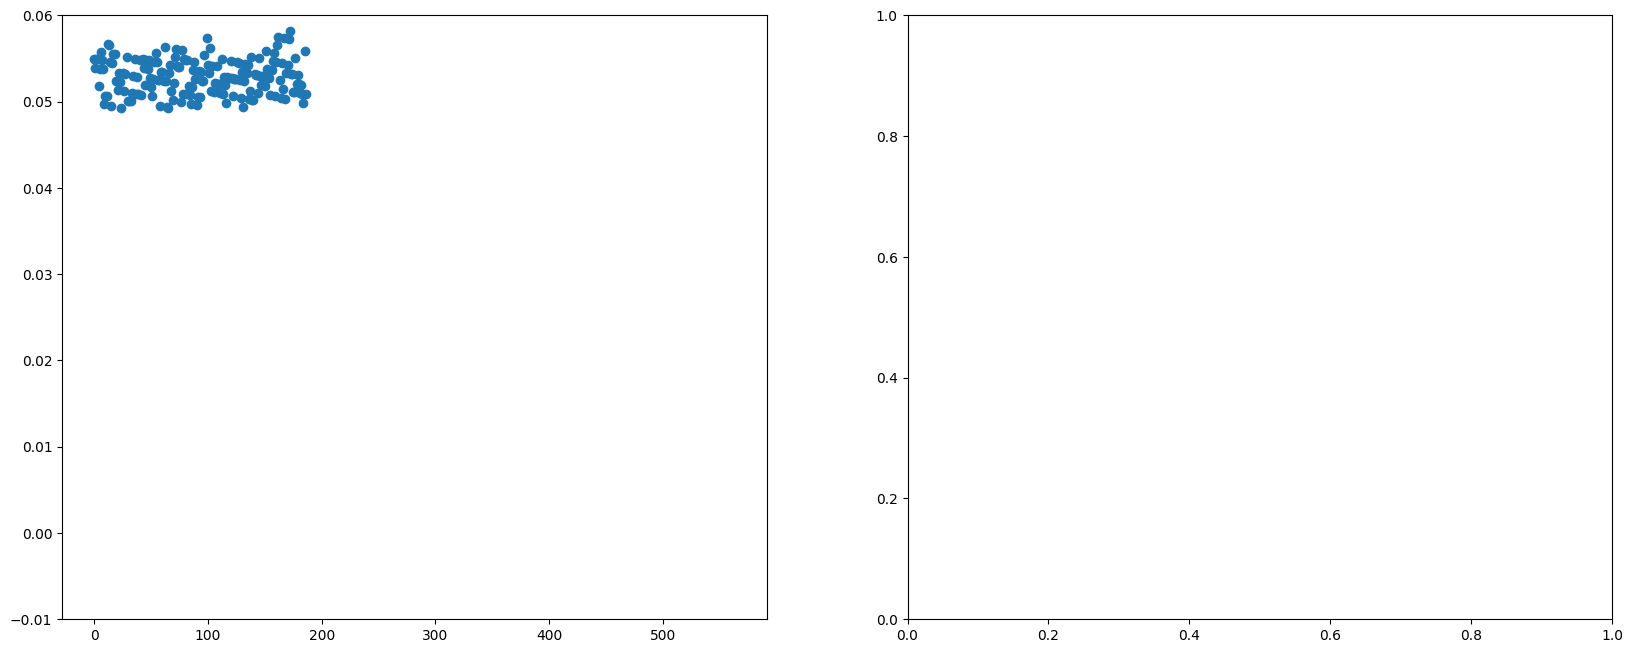

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=100)
ax[0].scatter(x=range(len(tl)), y=tl)
ax[0].set_ylim([-0.01, 0.06])

NameError: name 'trl' is not defined

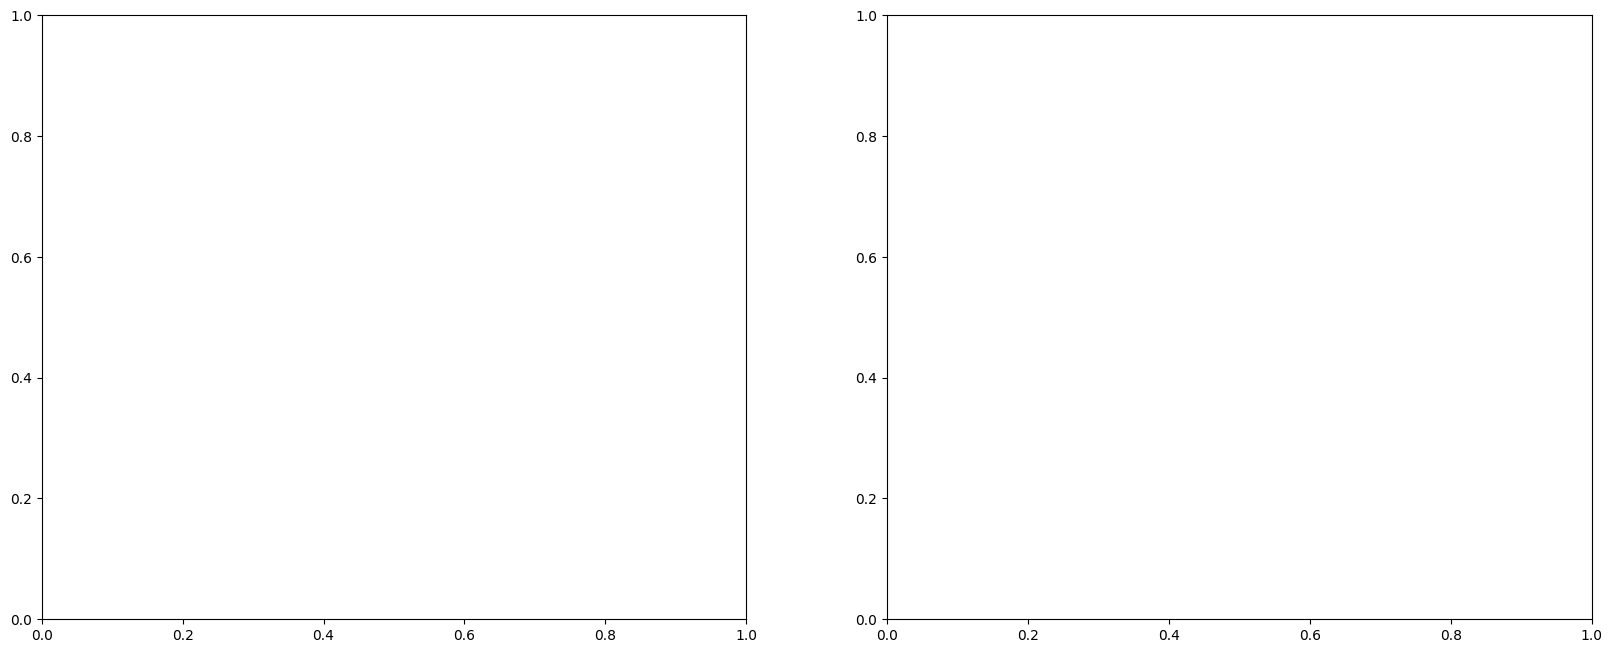

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=100)
ax[0].scatter(x=range(len(tcl)), y=trl)
ax[0].scatter(x=range(len(tcl)), y=twl)
ax[0].scatter(x=range(len(tcl)), y=tsl)
ax[0].scatter(x=range(len(tcl)), y=tcl)
ax[0].legend(['Read', 'Write', 'Sim', 'Total'])
ax[0].axhline(t_step, color='tab:red')
ax[0].set_xlim([0, len(tcl)])
ax[0].set_title("Data read time interval")
ax[0].set_ylabel("Time [s]")
ax[0].set_ylim([-0.05, 0.12])

ax[1].scatter(x=range(len(crl)), y=crl)
ax[1].set_xlim([0, len(crl)])
ax[1].set_title("Read counter")
ax[1].set_ylabel("Number")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), dpi=400)

ss.TDS.plt.plot(ss.Bus.v, a=(8),
                ax=ax[0], fig=fig,
                legend=False, show=False,
                title='Load bus voltage',
                ylabel='Voltage [p.u.]')

ss.TDS.plt.plot(ss.GENCLS.omega,
                ax=ax[1], fig=fig,
                legend=False, show=False,
                ytimes=ss.config.freq,
                title='Generator omega',
                ylabel='Frequency [Hz]')

In [ ]:
crl

In [ ]:
plt.plot(range(len(crl)), crl)
plt.title("Counter")
plt.xlabel("Seqence")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), dpi=400)

# ax[2].scatter(x=np.array(tl), y=np.array(fsl))
ax[0].plot(np.array(tl) - tl[0], np.array(fsl))
# ax[2].set_xlim([0, len(asl)])
ax[0].set_xlim([0, len(crl) * t_step])
ax[0].set_title("Freq. send")
ax[0].set_ylabel("p.u.")
ax[0].set_xlabel("Time [s]")

ax[1].plot(np.array(tl) - tl[0], np.array(vsl))
# ax[2].set_xlim([0, len(asl)])
ax[1].set_xlim([0, len(crl) * t_step])
ax[1].set_title("Volt. send")
ax[1].set_ylabel("p.u.")
ax[1].set_xlabel("Time [s]")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), dpi=400)

# ax[2].scatter(x=np.array(tl), y=np.array(fsl))
ax[0].plot(np.array(tl) - tl[0], np.array(prl))
# ax[2].set_xlim([0, len(asl)])
ax[0].set_xlim([0, len(crl) * t_step])
ax[0].set_title("P read")
ax[0].set_ylabel("p.u.")
ax[0].set_xlabel("Time [s]")


ax[1].plot(np.array(tl) - tl[0], np.array(qrl))
# ax[2].set_xlim([0, len(asl)])
ax[1].set_xlim([0, len(crl) * t_step])
ax[1].set_title("Q read")
ax[1].set_ylabel("p.u.")
ax[1].set_xlabel("Time [s]")

In [ ]:
ss.dae.ts.y[:, ss.Bus.v.a[8]]

In [ ]:
data1 = pd.DataFrame()
data1['fs'] = fsl
data1['vs'] = vsl
data1['pr'] = prl
data1['qr'] = qrl

data2 = pd.DataFrame()
data2['busv'] = ss.dae.ts.y[:, ss.Bus.v.a[8]]
data2['wg1'] = ss.dae.ts.x[:, ss.GENCLS.omega.a[0]]
data2['wg2'] = ss.dae.ts.x[:, ss.GENCLS.omega.a[1]]
data2['wg3'] = ss.dae.ts.x[:, ss.GENCLS.omega.a[2]]
data2['wg4'] = ss.dae.ts.x[:, ss.GENCLS.omega.a[3]]
data2['wg5'] = ss.dae.ts.x[:, ss.GENCLS.omega.a[4]]

data1.to_csv('data1_2.csv', index=False)
data2.to_csv('data2_2.csv', index=False)